In [0]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, mutual_info_score, ConfusionMatrixDisplay, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression

# Download the Data 
Keep this if you are working in Google Colab. Delete this if you are working on your own computer and have the data downloaded already. 

In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3' -O lendingclub.csv

--2020-02-10 03:59:16--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3
Resolving docs.google.com (docs.google.com)... 173.194.217.139, 173.194.217.138, 173.194.217.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/os6mfdjv6tnt3fnopg2leojrsmjcjvdd/1581306300000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download [following]
--2020-02-10 03:59:17--  https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/os6mfdjv6tnt3fnopg2leojrsmjcjvdd/1581306300000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download
Resolving doc-10-5c-docs.googleusercontent.com (doc-10-5c-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting

# Homework 2 (Due February 9, 2020)
Last week you trained a machine learning classifier to predict borrower success rates on LendingClub.com, using a set of features that were already present in the dataset. This week you will spend time optimizing that model.

Feel free to reuse code from your first homework submission; this does not need to be done from scratch.

# Question 1

Choose **ONE** of the following three options:

   - The `state` column is currently broken into 51 distinct values. Create a new feature, `region`, that groups similar states together.
   - The `emp_length` column is currently a nominal value. Create a new feature, `emp_length_numeric`, that treats the variable as a numeric value instead.
   - The `title` column is a free-form string and is currently hard or impossible to use as a feature. Define one or more features that capture information about the type of loan being applied for, based on the contents of the title.

For the option you have chosen, compare how switching to your new feature in a decision tree model improves or worsens performance compared to using the original representation. Report your quantitative results along with an explanation of your new feature's possible values.

In [0]:
# load data
lending = pd.read_csv("lendingclub.csv")

# create boolean variable to store outcome
lending['accepted'] = (lending['outcome'] == "accept")

# modify column features and type
# 1. group states into 5 regions
## return a region key to a state value
def get_regions(state, region_dict):
  region = 'not found'
  for k,v in region_dict.items():
    if state in v:
      region = k
  return region

## store states' regional groups
regions = {1:['WA','MT','OR','ID','WY','CA','NV','UT','CO','AK','HI'], #11
           2:['ND','SD','NE','KS','MN','IA','MO','WI','MI','IL','IN','OH'],#12
           3:['ME','VT','NH','MA','NY','RI','CT','PA','NJ'],#9
           4:['AZ','NM','OK','TX'],#4
           5:['AR','LA','KY','TN','MS','AL','GA','WV','MD','DE','DC','VA','NC','SC','FL']} #15

## add a region column with numeric labels
lending['region'] = lending['state'].apply(lambda x: get_regions(x, regions))

# 2. label emp_length with numeric flags
lending['emp_length_numeric'] = lending['emp_length']
lending['emp_length_numeric'].replace({
    '< 1 year': 0,
    '10+ years': 10,
    '5 years': 5,
    '9 years': 9,
    '6 years': 6,
    '2 years': 2,
    '3 years': 3,
    '7 years': 7,
    '8 years': 8,
    '4 years': 4,
    '1 year': 1
}, inplace=True)

# 3. extract loan type from title
## uniform text style
lending['loan_type'] = lending['title']
lending['loan_type'] = lending['loan_type'].str.lower()
lending['loan_type'] = lending['loan_type'].str.replace('_',' ')

## classify a title into a loan type group
def get_type(title, type_dict):
  type = 8
  for k,v in type_dict.items():
    for i in v:
      if i in title:
        type = k
        return type
  return type

## store type groups and key words
types = {1: ['car','purchase','bike','renewable energy','ring','motorcycle','auto','boat','equipment'],
         2: ['home','house','kitchen','pool','roof','remodel'],
         3: ['wedding','moving','vacation','relocation'],
         4: ['medical','dental'],
         5: ['educational','student', 'school','education','college'],
         6: ['business','investment','capital'],
         7: ['consolidation','credit card','credit cards','loan','consolidate',
                  'debt','payoff','bills','refinance','refinancing','pay off','payment','rent']}

## extract loan type information with numeric labels
lending['loan_type'] = lending['loan_type'].apply(lambda x: get_type(x, types))
lending['loan_type'].replace()

lending.head()

,amount,date,title,fico,dti,zip,state,emp_length,policy_code,year,outcome,accepted,region,emp_length_numeric,loan_type
0,2500.0,Dec-2011,bike,740.0,1.00,309xx,GA,< 1 year,1.0,2011,accept,True,5,0,1
1,12000.0,Dec-2011,Consolidation,675.0,10.78,913xx,CA,10+ years,1.0,2011,accept,True,1,10,7
2,21000.0,Dec-2011,Debt Cleanup,705.0,13.22,335xx,FL,10+ years,1.0,2011,accept,True,5,10,7
3,31825.0,Dec-2011,Debt Consolidation Loan,760.0,14.03,080xx,NJ,5 years,1.0,2011,accept,True,3,5,7
4,12000.0,Dec-2011,Debt Consolidation,725.0,16.70,088xx,NJ,10+ years,1.0,2011,accept,True,3,10,7


## Decoding Variables
In the process of decision tree training process, the following variables were used:
1. `fico`: the credit rating of the borrower
2. `amount`: the mount requested for the borrowers' first loan
3. `dti`: debt-to-income, a ratio of the borrower’s total monthly debt payments, excluding home mortgage and the requested loan, to the borrower’s self-reported monthly income
4. `state`: U.S. state that the borrower resides in
5. `emp_length`: Length of time that the borrower has been employed at their current job, from 0 to 10+ years
6. `title`: Title of the loan application written by the borrower

| Features | Type | min | mean  | max |
|------|------|---------|-----------|-----------|
| `fico` |numeric | 0.00|603.01 | 850.00|
|`amount`| numeric|500.00  | 12959.44  | 500000.00|
| `dti` |   numeric|-1.000000e+00|5.142695e+02|3.418800e+06|
|`state`|nominal classified into regional groups|
| `emp_length`|  nominal encoded w/ numeric labels|
|`title`|free-form string, from which categorical features were extracted|

The following 3 categorical variables were encoded with numeric labels for `DecisionTreeClassifier` to process as the following:


>### `region`
The U.S. states of the borrowers' residency were classified into 5 regional groups according to their geolocations and people's common sense:

|Code|Region|States|Counts|
|------|------|-----|----|
|1|west|WA MT OR ID WY CA NV UT CO AK HI|17580|
|2|midwest| ND SD NE KS MN IA MO WI MI IL IN OH |13290|
|3|northeast| ME VT NH MA NY RI CT PA NJ|17546|
|4|southwest|AZ NM OK TX|9606|
|5|southeast| AR LA KY TN MS AL GA WV MD DE DC VA NC SC FL |23081|

<br>

>### `emp_length_numeric`
The variable of the length of employment was labeled with numeric values representing the borrowers' numbers of years being employed:

|Code|Length of Employment|Count|
|----|----|---|
|0|< 1 year|57065|
|1|1 year|2963|
|2|2 years|3362|
|3|3 years|2690|
|4|4 years|2175|
|5|5 years|2135|
|6|6 years|1627|
|7|7 years|1243|
|8|8 years|1054|
|9|9 years|830|
|10+|10+ years|5959|
 
>### `loan_type`
Loan applications' loan_type features were extracted using key words from the description of the loan purpose written by the borrowers.

|Code|Type of Loan|Description|Count|
|----|-----|-----|----|
|1|purchase|major purchases include car, motorcycle, boat, etc.|17652|
|2|home remodel|house remodeling projects such as having kitchen and roof redone etc.|5082|
|3|event|big events such as wedding, vacation, relocation, etc.|4402|
|4|medical|medical and dental expenses|2050|
|5|educational|educational funds and student loans|1076|
|6|business|loans for business and investment purposes|4513|
|7|debt|credit card refinancing, consolidation and payoff|32021|
|8|other|loans with unspecified reasons|14307|

<br>








In [0]:
def decision_tree(data, feature_set, criterion, y_variable, test_size, df=False, splitter='best', max_depth=None, pure=0.0):
  '''train decision tree models with selected features
  and some hyperparameters by default to tune later,
  df: whether to return the results as a dictionary that can be convert into a dataframe'''

  index = 1
  records = []
  for feature_name, feature in feature_set.items():
    X = data.loc[:, feature]
    y = data[y_variable]

    # split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    # train the models
    model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_impurity_decrease=pure).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ignore UndefinedMetricWarning caused by ill-preforming single nominal features, and RuntimeWarnings later
    warnings.filterwarnings("ignore")

    # calculate metrics needed for model evaluation
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)

    train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)

    # store metrics to keep track
    record_dict = {'Variable(s)': feature_name,
                   'Leaves': model.get_n_leaves(),
                   'Test_Accuracy(%)': round(100*accuracy,3),
                   'Train_Accuracy(%)': round(100*train_accuracy,3),
                   'Kappa': round(kappa,3),
                   'Precision': round(precision,3),
                   'Recall':round(recall,3),
                   'F_Score': round(f,3)}
    records.append(record_dict)

    # print the results of the calculation of the metrics
    if df == False:
      print(f"{index}. {feature_name}:")
      print(f"      Number of Leaves: {model.get_n_leaves()}")
      print(f"      Accuracy: {100*accuracy:.2f}%")
      print(f"      Kappa: {kappa:.3f}")
      print(f"      Precision: {precision:.3f}")
      print(f"      Recall: {recall:.3f}")
      print(f"      F-Score: {f:.3f}")
      print("      Confusion Matrix:")
      conf_matrix = confusion_matrix(y_test, y_pred)
      ConfusionMatrixDisplay(conf_matrix, ["Rejected", "Accepted"]).plot(values_format='.4g')
      plt.show()
      index += 1

  if df:
    return records

In [0]:
single_features = {"fico":['fico'],
                   'amount':['amount'],
                   'dti':['dti'],
                   'region':['region'],
                   'emp_len': ['emp_length_numeric'],
                   'loan_ty':['loan_type']}

# train decision tree using selected single features
single_features_df = pd.DataFrame(decision_tree(lending, single_features, "entropy", 'accepted', 0.3, df=True))
single_features_df.sort_values(by='Test_Accuracy(%)', ascending=False, inplace=True)
single_features_df

,Variable(s),Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa,Precision,Recall,F_Score
0,fico,81,92.655,92.755,0.717,0.610,0.997,0.757
1,amount,782,89.561,90.504,0.255,0.660,0.188,0.293
3,region,5,88.508,88.641,0.000,0.000,0.000,0.000
4,emp_len,11,88.508,88.641,0.000,0.000,0.000,0.000
5,loan_ty,8,88.508,88.641,0.000,0.000,0.000,0.000
2,dti,3059,88.307,88.699,0.008,0.242,0.008,0.016


## Q1 Analysis
Encoding nominal features allows DecisionTreeClassifier to process the feature as a single independent variable. Comparing to using original 51 states, free-form title descriptions and length of employment strings, encoded version provide us more information about an application and may actually faciliitate model training.

Switching from quantitative variables, such as `fico` score, `amount` of loan and `dti` score, to encoded nominal features like `region`, `length of employment` and `type of loan`, the test accuracy turned from irregular numbers to about 88.5% for all three and other metrics to 0. This implys that those three features (`region`, `emp_length_numeric`, `loan_type`) have no direct or obvious corrlation with the outcome of applications and cannot serve independently as an explanatory variable to predict application results. The percantage of 88.5 is the proportion of rejected applications among all, meaning that naturally by simply guessing every loan to fail, there is a 88.5% chance to predict correctly. For example, in the case of `region`, the number of cases predicted to be accepted is 0, which is definitely not what we want, implying that `region` is a not suitable x_variable to train the models with.

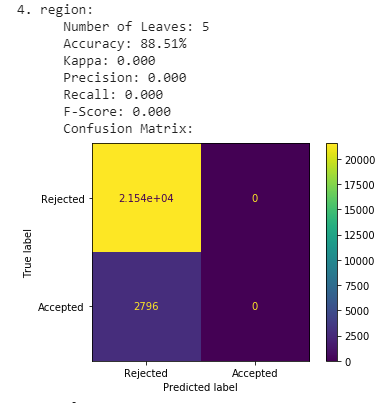

Among already tested single features, `fico` is performing the best with a comparatively small-sized tree with only 81 leaves and a satisfying accuracy of 92.55%. That is to say, `fico` should best be included in future model training as an explanatory variable.

# Question 2

Choose **THREE** of the following five options:
1. Amount of data available for training.
2. Subset of features included in the model.
3. Decision tree vs. logistic regression classification.
4. Hyperparameter tuning for the best-performing model from option 3.
5. Number of folds or stratification strategy for cross-validation.

For each option you choose, write code to see how much impact that option has on model performance. For instance, you might choose to measure prediction accuracy as the amount of available data is increased from 1% of the total training set to 100%.

Note that for logistic regression classification, the default decision boundary may not produce the best model; you will likely want to check different decision boundaries if you choose options 3 and 4.

Rank the three options you chose from the greatest impact on model performance to the least impact. Justify your ranking, based on specific quantitative experimental evidence.

### Q2-1 Adjusting Train Set Size

In [0]:
def diff_size_accuracy(feature_set):

  output_df = {'Variable(s)': [],
              'Leaves': [],
              'Test_Accuracy(%)': [],
              'Train_Accuracy(%)': [],
              'Kappa': [],
              'Precision': [],
              'Recall':[],
              'F_Score': [],
              'train_size(%)':[]}

  # control data size
  data_size = 1
  while data_size > 0.11:
    diff_data = lending.iloc[lending.index < len(lending)*data_size]

    # train model using data of different sizes
    train_size = decision_tree(diff_data, feature_set, "entropy", 'accepted', 0.3, df=True)
    train_size[0]['train_size(%)'] = round(data_size*100)

    # store values into the new dataframe
    for key,value in train_size[0].items():
      if key in output_df:
        output_df[key].append(train_size[0][key])

    data_size -= 0.01

  # plot scatter points to show the changes in accuracy
  df = pd.DataFrame(output_df)
  df.sort_values(by='Test_Accuracy(%)', ascending=False, inplace=True)
  ax = df.plot.scatter(x='train_size(%)',y='Test_Accuracy(%)',c='purple')
  df.plot.scatter(x='train_size(%)',y='Train_Accuracy(%)',c='orange', ax=ax)
  ax.set_xlabel("Train Size(%)")
  ax.set_ylabel("Accuracy(%)")
  ax.legend(["Testing Accuracy","Training Accuracy"])
  plt.show()

  return df

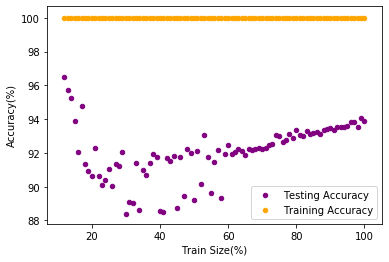

,Variable(s),Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa,Precision,Recall,F_Score,train_size(%)
88,fico+amount+dti,224,96.507,100.000,0.646,0.983,0.981,0.982,12
87,fico+amount+dti,333,95.733,100.000,0.796,0.973,0.979,0.976,13
86,fico+amount+dti,398,95.245,100.000,0.832,0.967,0.975,0.971,14
83,fico+amount+dti,581,94.755,100.000,0.880,0.954,0.968,0.961,17
1,fico+amount+dti,3293,94.043,99.991,0.708,0.748,0.736,0.742,99
...,...,...,...,...,...,...,...,...,...
55,fico+amount+dti,2628,88.758,100.000,0.704,0.785,0.773,0.779,45
66,fico+amount+dti,1949,88.601,99.990,0.747,0.834,0.833,0.833,34
60,fico+amount+dti,2370,88.575,99.996,0.725,0.813,0.799,0.806,40
59,fico+amount+dti,2369,88.522,99.991,0.721,0.796,0.806,0.801,41


In [0]:
fad = {'fico+amount+dti':['fico','amount','dti']}
diff_size_accuracy(fad)

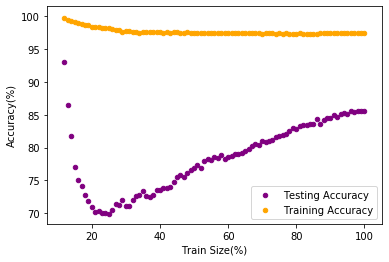

,Variable(s),Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa,Precision,Recall,F_Score,train_size(%)
88,amount+dti,533,92.979,99.750,0.263,0.962,0.964,0.963,12
87,amount+dti,1087,86.504,99.458,0.364,0.922,0.924,0.923,13
1,amount+dti,8448,85.574,97.482,0.260,0.363,0.320,0.340,99
0,amount+dti,8518,85.558,97.520,0.249,0.353,0.309,0.330,100
4,amount+dti,8391,85.530,97.473,0.271,0.383,0.325,0.352,96
...,...,...,...,...,...,...,...,...,...
78,amount+dti,3594,70.297,98.375,0.406,0.716,0.702,0.709,22
79,amount+dti,3409,70.215,98.322,0.402,0.725,0.716,0.720,21
77,amount+dti,3849,70.109,98.147,0.402,0.707,0.685,0.695,23
76,amount+dti,3971,70.068,98.194,0.399,0.698,0.665,0.681,24


In [0]:
ad = {'amount+dti':['amount','dti']}
diff_size_accuracy(ad)

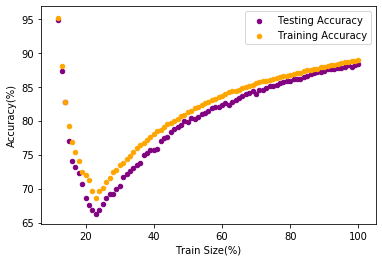

,Variable(s),Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa,Precision,Recall,F_Score,train_size(%)
88,region+emp_length+loan_type,180,94.760,95.039,-0.003,0.949,0.999,0.973,12
0,region+emp_length+loan_type,425,88.406,88.922,0.131,0.479,0.100,0.165,100
1,region+emp_length+loan_type,425,88.256,88.816,0.161,0.481,0.128,0.202,99
3,region+emp_length+loan_type,422,88.145,88.616,0.224,0.506,0.188,0.274,97
2,region+emp_length+loan_type,424,87.901,88.775,0.147,0.461,0.118,0.188,98
...,...,...,...,...,...,...,...,...,...
75,region+emp_length+loan_type,415,67.680,70.147,0.352,0.643,0.676,0.659,25
79,region+emp_length+loan_type,407,67.573,71.246,0.342,0.675,0.761,0.715,21
76,region+emp_length+loan_type,418,66.815,69.585,0.335,0.655,0.654,0.655,24
78,region+emp_length+loan_type,417,66.804,69.664,0.333,0.662,0.729,0.694,22


In [0]:
rlt = {'region+emp_length+loan_type': ['region','emp_length_numeric','loan_type']}
diff_size_accuracy(rlt)

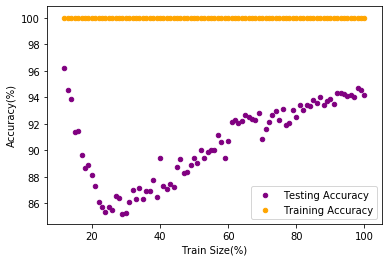

,Variable(s),Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa,Precision,Recall,F_Score,train_size(%)
88,everything,207,96.233,100.0,0.603,0.979,0.981,0.980,12
2,everything,2496,94.703,100.0,0.744,0.784,0.764,0.774,98
1,everything,2497,94.587,100.0,0.734,0.772,0.758,0.765,99
87,everything,341,94.532,100.0,0.740,0.967,0.971,0.969,13
7,everything,2435,94.361,100.0,0.737,0.780,0.759,0.769,93
...,...,...,...,...,...,...,...,...,...
77,everything,1409,85.707,100.0,0.714,0.862,0.850,0.856,23
74,everything,1580,85.491,100.0,0.707,0.828,0.851,0.839,26
76,everything,1443,85.325,100.0,0.706,0.845,0.851,0.848,24
70,everything,1749,85.233,100.0,0.689,0.810,0.809,0.810,30


In [0]:
evry = {'everything': ['fico','amount','dti','region','emp_length_numeric','loan_type']}
diff_size_accuracy(evry)

### Q2-1 Analysis
All four models using different sets of features shows a simillar pattern of correlation between amount of data used to train models and testing set accuracies. For models with data size smaller than anout 30% of the whole dataset, the accuracy is strongly negatively related to the size; for models with more than 30% amount of data, the accuracy increases as the data size expand. The first part of the correlation with very high bias is caused by the unevenly distributed binary values of the `outcome` variable.

The generalized relationship between data size and accuracy in this case is pisitive: the bigger the data size is (above 30%), the higher the accuracy of the model will be.

### Q2-2 Subset the Features

In [0]:
feature_sets = {'fico+amount':['fico','amount'],
                'fico+dti':['fico','dti'],
                'amount+dti':['amount','dti'],
                'original (fico+amount+dti)': ['fico','amount','dti'],
                'original+region': ['fico','amount','dti','region'],
                'original+emp_length': ['fico','amount','dti','emp_length_numeric'],
                'original+loan_type' : ['fico','amount','dti','loan_type'],
                'region+emp_length+loan_type': ['region','emp_length_numeric','loan_type'],
                'everything': ['fico','amount','dti','region','emp_length_numeric','loan_type']}

feature_sets_df = pd.DataFrame(decision_tree(lending, feature_sets, "entropy", 'accepted', 0.3, df=True))
feature_sets_df.sort_values(by='Test_Accuracy(%)', ascending=False, inplace=True)
feature_sets_df

,Variable(s),Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa,Precision,Recall,F_Score
5,original+emp_length,2736,94.595,100.000,0.734,0.767,0.761,0.764
8,everything,2600,94.213,100.000,0.712,0.755,0.735,0.745
3,original (fico+amount+dti),3306,93.950,99.991,0.702,0.737,0.736,0.736
1,fico+dti,3711,93.584,99.558,0.681,0.727,0.708,0.717
6,original+loan_type,3151,93.564,99.998,0.683,0.721,0.718,0.719
4,original+region,3161,93.556,99.996,0.683,0.720,0.718,0.719
0,fico+amount,1862,93.510,95.683,0.671,0.734,0.683,0.708
7,region+emp_length+loan_type,425,88.406,88.922,0.131,0.479,0.100,0.165
2,amount+dti,8521,85.603,97.520,0.250,0.355,0.309,0.330


Text(0.5, 1.0, 'Test and Train Accuracy')

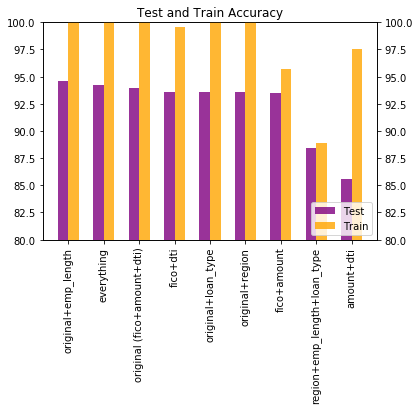

In [0]:
# plot test and train set accuracies of different variable sets
x = np.arange(9)
ax1 = plt.subplot(1,1,1)
w = 0.3

plt.xticks(x + w /2, feature_sets_df['Variable(s)'], rotation='vertical')
test =ax1.bar(x, feature_sets_df['Test_Accuracy(%)'], width=w, color='purple', align='center',alpha=0.8)
plt.ylim(80,100)
ax2 = ax1.twinx()
train =ax2.bar(x + w, feature_sets_df['Train_Accuracy(%)'], width=w,color='orange',align='center',alpha=0.8)
plt.legend([test,train],["Test","Train"], loc="lower right")
plt.ylim(80,100)
plt.title('Test and Train Accuracy')

###Q2-3 Decsion Tree vs Logictic Regression

In [0]:
def logistic_regression(data, feature_set, y_feature, test_size, df=False):

  records = []
  count = 1
  for set_name,x_feature in feature_set.items():
    # Prepare data
    X = data.loc[:, x_feature]
    # X = pd.get_dummies(X)
    y = data[y_feature]

    # Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    classifier = LogisticRegression(penalty="none", solver="lbfgs", max_iter=10000, random_state=1)
    model = classifier.fit(X_train, y_train)

    # Get Predictions
    y_pred = model.predict(X_test)

    # Compute and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)

    train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)

    record_dict = {'Variable(s)': set_name,
                    'Test_Accuracy(%)': round(100*accuracy,3),
                    'Train_Accuracy(%)': round(100*train_accuracy,3),
                    'Kappa': round(kappa,3),
                    'Precision': round(precision,3),
                    'Recall':round(recall,3),
                    'F_Score': round(f,3),
                   'Classifier':'Logistic Regression'}
    records.append(record_dict)

    if df == False:
      print(f"      Accuracy: {100*accuracy:.2f}%")
      print(f"      Kappa: {kappa:.3f}")
      print(f"      Precision: {precision:.3f}")
      print(f"      Recall: {recall:.3f}")
      print(f"      F-Score: {f:.3f}")
      print("      Confusion Matrix:")
      conf_matrix = confusion_matrix(y_test, y_pred)
      ConfusionMatrixDisplay(conf_matrix, ["Rejected", "Accepted"]).plot(values_format='.4g')
      plt.show()
    
  if df:
    return records

In [0]:
# structure output
output_df_lr = {'Classifier':[],
              'Variable(s)': [],
              'Test_Accuracy(%)': [],
              'Train_Accuracy(%)': [],
              'Kappa': [],
              'Precision': [],
              'Recall':[],
              'F_Score': []}

# select all the features sets to test
many_features = {"fico":['fico'],
                   'amount':['amount'],
                   'dti':['dti'],
                   'region':['region'],
                   'emp_len': ['emp_length_numeric'],
                   'loan_ty':['loan_type'],
                   'fico+amount':['fico','amount'],
                    'fico+dti':['fico','dti'],
                    'amount+dti':['amount','dti'],
                    'original (fico+amount+dti)': ['fico','amount','dti'],
                    'original+region': ['fico','amount','dti','region'],
                    'original+emp_length': ['fico','amount','dti','emp_length_numeric'],
                    'original+loan_type' : ['fico','amount','dti','loan_type'],
                    'region+emp_length+loan_type': ['region','emp_length_numeric','loan_type'],
                    'everything': ['fico','amount','dti','region','emp_length_numeric','loan_type']}

# run logistic regression model
lr = logistic_regression(lending, many_features, 'accepted', 0.3, df=True)
for dic in lr:
  for key,value in dic.items():
    if key in output_df_lr:
      output_df_lr[key].append(dic[key])

# run decision tree model
dt = decision_tree(lending, many_features, 'entropy', 'accepted', 0.3, df=True)
for dic2 in dt:
  dic2['Classifier'] = 'Decision Tree'
  for key,value in dic2.items():
    if key in output_df_lr:
      output_df_lr[key].append(dic2[key])

# sort output by test accuracy
lr_vs_dt = pd.DataFrame(output_df_lr)
lr_vs_dt.sort_values(by='Test_Accuracy(%)', ascending=False,inplace=True)
lr_vs_dt

,Classifier,Variable(s),Test_Accuracy(%),Train_Accuracy(%),Kappa,Precision,Recall,F_Score
26,Decision Tree,original+emp_length,94.460,100.000,0.725,0.764,0.749,0.756
29,Decision Tree,everything,94.160,100.000,0.709,0.753,0.732,0.742
24,Decision Tree,original (fico+amount+dti),93.942,99.991,0.702,0.736,0.737,0.737
25,Decision Tree,original+region,93.654,99.996,0.687,0.725,0.721,0.723
27,Decision Tree,original+loan_type,93.650,99.998,0.687,0.725,0.721,0.723
22,Decision Tree,fico+dti,93.584,99.558,0.681,0.727,0.708,0.717
21,Decision Tree,fico+amount,93.510,95.683,0.671,0.734,0.683,0.708
15,Decision Tree,fico,92.655,92.755,0.717,0.610,0.997,0.757
16,Decision Tree,amount,89.561,90.504,0.255,0.660,0.188,0.293
8,Logistic Regression,amount+dti,88.508,88.641,0.000,0.000,0.000,0.000


Text(0.5, 1.0, 'Logistic Regression VS Decision Tree')

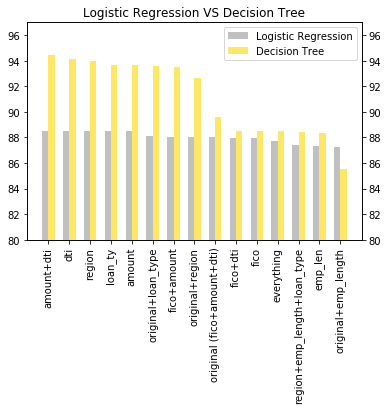

In [0]:
# plot different sets' accuracies for both LR and DT models
lr_df = lr_vs_dt.loc[lr_vs_dt.Classifier == 'Logistic Regression']
dt_df = lr_vs_dt.loc[lr_vs_dt.Classifier == 'Decision Tree']

x = np.arange(15)
ax1 = plt.subplot(1,1,1)
w = 0.3

plt.xticks(x + w /2, lr_df['Variable(s)'], rotation='vertical')
lrp =ax1.bar(x, lr_df['Test_Accuracy(%)'], width=w, color='silver', align='center')
plt.ylim(80,97)
ax2 = ax1.twinx()
dtp =ax2.bar(x + w, dt_df['Test_Accuracy(%)'], width=w,color='gold',align='center',alpha=0.6)
plt.legend([lrp,dtp],["Logistic Regression","Decision Tree"], loc="upper right")
plt.ylim(80,97)
plt.title('Logistic Regression VS Decision Tree')

### Q2-4 Tuning Hyperparameters
* criterion
* tree size (max_depth)
* definition of purity

In [0]:
# select the wining feature set form Q2-3
winner_feature = {'fico+amount+dti+emp_length':['fico','amount','dti','emp_length_numeric']}

# structure output
output_df_tuning = {'Variable(s)': [],
                    'Criterion':[],
                    'Max_Depth':[],
                    'Purity':[],
                    'Leaves':[],
                    'Test_Accuracy(%)': [],
                    'Train_Accuracy(%)': [],
                    'Kappa': []}

# list hyperparameter options
criteria = ['entropy','gini']
max_dept = range(5,51,5)
purity = [0, 0.0001, 0.001, 0.01, 0.1]

# train models with different hyperparameters
for crit in criteria:
  for depth in max_dept:
    for pur in purity:
      tree = decision_tree(lending, winner_feature, crit, 'accepted', 0.3, df=True, max_depth=depth, pure=pur)[0]
      tree['Criterion'] = crit
      tree['Max_Depth'] = depth
      tree['Purity'] = pur
      for key,value in tree.items():
        if key in output_df_tuning:
          output_df_tuning[key].append(tree[key])

# sort output by test accuracy
tuning_df = pd.DataFrame(output_df_tuning)
tuning_df.sort_values(by='Test_Accuracy(%)', ascending=False, inplace=True)
tuning_df

,Variable(s),Criterion,Max_Depth,Purity,Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa
96,fico+amount+dti+emp_length,gini,50,0.0001,95,95.487,95.889,0.766
46,fico+amount+dti+emp_length,entropy,50,0.0001,177,95.467,95.915,0.771
91,fico+amount+dti+emp_length,gini,45,0.0001,93,95.458,95.859,0.765
41,fico+amount+dti+emp_length,entropy,45,0.0001,170,95.352,95.829,0.766
86,fico+amount+dti+emp_length,gini,40,0.0001,88,95.339,95.721,0.760
...,...,...,...,...,...,...,...,...
44,fico+amount+dti+emp_length,entropy,45,0.1000,2,88.508,88.641,0.000
49,fico+amount+dti+emp_length,entropy,50,0.1000,2,88.508,88.641,0.000
64,fico+amount+dti+emp_length,gini,15,0.1000,1,88.508,88.641,0.000
54,fico+amount+dti+emp_length,gini,5,0.1000,1,88.508,88.641,0.000


In [0]:
tuning_df.loc[tuning_df.Max_Depth == 25]

,Variable(s),Criterion,Max_Depth,Purity,Leaves,Test_Accuracy(%),Train_Accuracy(%),Kappa
71,fico+amount+dti+emp_length,gini,25,0.0001,71,94.546,94.957,0.727
21,fico+amount+dti+emp_length,entropy,25,0.0001,150,94.472,94.975,0.731
20,fico+amount+dti+emp_length,entropy,25,0.0000,1919,93.971,97.837,0.716
70,fico+amount+dti+emp_length,gini,25,0.0000,1881,93.843,97.775,0.706
72,fico+amount+dti+emp_length,gini,25,0.0010,7,91.977,92.509,0.615
22,fico+amount+dti+emp_length,entropy,25,0.0010,12,91.965,92.465,0.621
73,fico+amount+dti+emp_length,gini,25,0.0100,4,90.637,90.719,0.615
23,fico+amount+dti+emp_length,entropy,25,0.0100,5,89.589,89.359,0.609
24,fico+amount+dti+emp_length,entropy,25,0.1000,2,88.508,88.641,0.000
74,fico+amount+dti+emp_length,gini,25,0.1000,1,88.508,88.641,0.000


###Q2-5

In [0]:
output_df_kfold = {'Variable(s)': [],
                    'Leaves':[],
                    'Folds':[],
                    'Fold_Num':[],
                    'Test_Accuracy(%)': [],
                    'Train_Accuracy(%)': [],
                    'Kappa': []}

def decision_tree_kf(data, feature_set, criterion, y_variable, test_size, splitter='best', max_depth=None, pure=0.0, kf_num=10):

  records = []
  for feature_name, feature in feature_set.items():
    X = data.loc[:, feature]
    y = data[y_variable]
    kf = KFold(n_splits=kf_num, shuffle=True)

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
      # Get the data subset for the current fold
      X_train = X.iloc[train_index]
      X_test = X.iloc[test_index]
      y_train = y.iloc[train_index]
      y_test = y.iloc[test_index]

      # train the models
      model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_impurity_decrease=pure).fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # ignore UndefinedMetricWarning caused by ill-preforming single nominal features, and RuntimeWarnings later
      warnings.filterwarnings("ignore")

      # calculate metrics needed for model evaluation
      accuracy = accuracy_score(y_test, y_pred)
      kappa = cohen_kappa_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f = f1_score(y_test, y_pred)

      train_pred = model.predict(X_train)
      train_accuracy = accuracy_score(y_train, train_pred)

      # store metrics to keep track
      record_dict = {'Variable(s)': feature_name,
                    'Fold_Num': fold_num,
                    'Leaves': model.get_n_leaves(),
                    'Test_Accuracy(%)': round(100*accuracy,3),
                    'Train_Accuracy(%)': round(100*train_accuracy,3),
                    'Kappa': round(kappa,3)}
      records.append(record_dict)

  return records

folds = range(5,11,1)
for i in folds:
  trees = decision_tree_kf(lending, winner_feature, 'gini', 'accepted', 0.3, splitter='best', max_depth=5, pure=0.0, kf_num=i)
  for tree in trees:
    tree['Folds'] = i
    for key,value in tree.items():
      if key in output_df_kfold:
        output_df_kfold[key].append(tree[key])

# sort output by test accuracy
fold_df = pd.DataFrame(output_df_kfold)
fold_df.sort_values(by='Test_Accuracy(%)', ascending=False, inplace=True)
fold_df

,Variable(s),Leaves,Folds,Fold_Num,Test_Accuracy(%),Train_Accuracy(%),Kappa
9,fico+amount+dti+emp_length,25,6,4,92.802,92.257,0.647
24,fico+amount+dti+emp_length,24,8,6,92.770,92.282,0.639
7,fico+amount+dti+emp_length,27,6,2,92.691,92.279,0.639
43,fico+amount+dti+emp_length,25,10,8,92.688,92.310,0.631
31,fico+amount+dti+emp_length,24,9,5,92.565,92.322,0.644
17,fico+amount+dti+emp_length,25,7,6,92.534,92.318,0.632
21,fico+amount+dti+emp_length,25,8,3,92.533,92.315,0.649
18,fico+amount+dti+emp_length,25,8,0,92.523,92.323,0.630
15,fico+amount+dti+emp_length,25,7,4,92.508,92.314,0.629
32,fico+amount+dti+emp_length,25,9,6,92.498,92.322,0.640


### Q2-Ranking and Explanation
#### Impact on Performance Ranking
|Rank|Option Index|Optimizing Options|Reason|
|----|-----|----|-----|
|1|O2|Feature Sets|direct, efficient, meaningful|
|2|O4|Hyperparameter Tuning|size-controlling, prevent overfitting|
|3|O1|Data Size|high cost of data collection, depends on feature selection|
|4|O3|Classifier Selection|direct, effect depend on case scenarios|
|5|O5|Number of Folds/Stratification|evaluate preformance without direct model tuning|

<br>

#### Explanation
1. Given the features of LengingClub data,  I found the selection of features works most directly and dramatically on the performance of the models. When using not very informative single nominal variables in Q1, we see that the Kappa of certain models dropped to 0 due to the weakness of those features as explanatory variables. Also, in Q2-2, there was a 10 percent difference from best performing feature set and worst performing set, indicating a strong influence of feature selection over model performance.

2. The second greatest influencing factors in this case I think is hyperparameter tuning. While tunig some hyperparameters, such as the depth of the tree and the split of data, may actully lower the accuracy, it downsizes the tree efficiently from more many thousand of leaves to about 20, preventing potential overfitting and high variance.

3. Reading from the scatter plots, data size can influence the accuracy of model prodictions quite obviously as well. I rank data size only in third place because, firstly, the cost (time and money) to collect more data in real life can be pretty high, and secondly, the influence of data size on model performance varies with different feature sets. For example, in Q2-1 plot of `fico+amount+dti`, data size larger than 60% doesn't change the accuracy too much.

4. On average, in this case, Decision Tree models outperform Logistic Regression models by 3.5% of accuracy. But it also depends on feature selection and the difference can be insignificant sometimes.

5. As the number of folds gets larger, the bias of the models become smaller due to difference in training set and testing sets decreases. But I feel that the number of folds doesn't work directly on improving model performance and only evaluates the model better. Also, reading from the table, the differences between 10 folds and 6 folds is not super big as well.

# Question 3

Report the best-performing model and the total set of choices that you made in the options above to get to that level of performance. Compare that model performance to the result you reported in Homework 1. 

   - Describe one hypothetical business context for LendingClub where the amount of improvement reported in Question 3 would be worth the extra time and effort needed for optimization.
   - Describe one hypothetical business context where the improvement would **not** have been worth the extra time and effort.

The best performing model in my mind is a Decision Tree trained with `fico+amount+dti+emp_length_numeric` feature set using `gini` criterion with max depth being 25 and purity being 0.0001 and other hyperparameters by default.

||hw1 results|hw2 results|
|-------|------|-----|
|Variable Used|fico+amount+dti+len|fico+amount+dti+len|
|Criterion|entropy|gini|
|Max Depth|None|25|
|Purity|0.0|0.0001|
|Number of Leaves|2750|71|
|Accuracy|94.6%|94.546%|
|Kappa|0.73|0.727|

<br>

Since the set of features I used for hw1 was already the best performing set I picked after comparing different sets, the major change in my model this time is the size of the tree. The problem with 2750 leaves is that the model is overfitting with too high variance, and 71 leaves seem more sensible.

With higher accuracy (not obvious in my case though) and smaller size (shorter processing time maybe?) optimization:
* worth-it context: Among the applicants predicted to be rejected, a lot of people can prove their repayability with proof other than fico, dti and length of employment, i.e. there is a high chance of inceasing business given the prediction results. Thus, the higher accuracy and the shorter processing time (?) will be worth it given the potential gain from business.

* not-worth-it context: Even though we predict an application's outcome successfully, there's not much we can do with the result, i.e. we can't turn it into a business opportunity nor can we compensate the cost of optimizing with cash or benefits or positive reviews, etc.

# Extra Credit

For up to 2 points of extra credit, complete all three of the analyses in Question 1.

For up to 4 points of extra credit, complete all five of the analyses in Question 2.

# Scoring Rubric
![](https://drive.google.com/uc?export=view&id=1dLF4RcciHT_giZEXWio1D0hwK73tKYjK)

![](https://drive.google.com/uc?export=view&id=1nYN7X847FeHtE-0LVpqhQk8iq2YEWx2d)